In [17]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('seaborn-poster')

In [121]:
df_epic = pd.read_hdf('../data/e2trigs_20160201_20170101.h5', 'e2trigs')

In [131]:
# get the s2cell token for all the triggers
df_epic = df_epic.assign(
    s2_token=list(map(s2_utils.get_cell_token_and_loc_from_latlng,
                      df_epic['lat'].values,
                      df_epic['lon'].values)))

In [134]:
from typing import Tuple, Union

class s2utils(object):
    def __init__(self):
        pass
    
    def get_cell_token_and_loc_from_latlng(self,
                                           lat_degree: float,
                                           lng_degree: float,
                                           level:int=11,
                                           include_loc:bool=False)\
        -> Union[str,
                 Tuple[str,
                       Tuple[float, float]]]:
        """
        from lat, lon to cellId token, latitude and longitude of the cell
        """
        
        lat_lon = s2sphere.LatLng.from_degrees(lat_degree, lng_degree)
        cellId = s2sphere.CellId.from_lat_lng(lat_lon).parent(level)
        
        if include_loc:
            cell_lat_degree = cellId.to_lat_lng().lat().degrees
            cell_lng_degree = cellId.to_lat_lng().lng().degrees
            return cellId.to_token(), (cell_lat_degree, cell_lng_degree)
        else:
            return cellId.to_token()
    
    def get_coverage_rect(self,
                          llat_degree:float,
                          ulat_degree:float,
                          llon_degree:float,
                          ulon_degree:float,
                          min_level:int=11,
                          max_level:int=11,
                          max_cells:int=100):
        """Function to get the s2cell coverage in a rect region.
        
        Args:
            llat_degree: lower latitude in degree. 
            ulat_degree: upper latitude in degree. 
            llon_degree: lower longitude in degree. 
            ulon_degree: upper longitude in degree. 
            min_level: minimum level of s2 cell. 
            max_level: maximum level of s2 cell.
            max_cells: the maximum number of cells to use. 
            
        Returns:
            covering: a list of s2 cells in the covering. 
        """
        region_rect = s2sphere.LatLngRect(
                s2sphere.LatLng.from_degrees(
                    llat_degree, llon_degree),
                s2sphere.LatLng.from_degrees(
                    ulat_degree, ulon_degree))
        
        coverer = s2sphere.RegionCoverer()
        coverer.min_level = min_level
        coverer.max_level = max_level
        coverer.max_cells = max_cells
        covering = coverer.get_covering(region_rect)
        
        return covering
    
    def get_covering_vertices(self, covering):
        """Function to get the vertices of the cells in a covering. 
        
        Args:
            covering: the covering of s2cell in a region. 
        Returns:
            vertices: list of tuples contain the 4 corners of the cells.
        """
        vertices = []
        for cellid in covering:
            new_cell = s2sphere.Cell(cellid)
            vertices_cell = []
            for i in range(0, 4):
                vertex = new_cell.get_vertex(i)
                latlng = s2sphere.LatLng.from_point(vertex)
                vertices_cell.append((latlng.lng().degrees,
                                      latlng.lat().degrees))
                
            vertices.append(vertices_cell)
                
        return vertices

In [153]:
df_select = df_epic.iloc[:100]

In [149]:
import s2sphere
import matplotlib.patches as patches

class GenerateImage:
    """class to generate images for detection. 
    """
    
    def __init__(self,
                 llat_degree,
                 ulat_degree,
                 llon_degree,
                 ulon_degree,):
        
        self.llat_degree = llat_degree
        self.ulat_degree = ulat_degree 
        self.llon_degree = llon_degree 
        self.ulon_degree = ulon_degree 
    
    def make_map(self,
                 figsize=(12,8),
                 plot_background=False):
        
        s2_utils = s2utils()
        
        plt.figure(figsize=figsize)
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.set_extent([self.llon_degree, self.ulon_degree, self.llat_degree, self.ulat_degree])
        
        if plot_background:
            land_50m = cfeature.NaturalEarthFeature(
                'physical', 'land', '50m',
                edgecolor='k',
                facecolor=cfeature.COLORS['land'])

            ocean_50m = cfeature.NaturalEarthFeature(
                'physical', 'ocean', '50m',
                edgecolor='k',
                facecolor=cfeature.COLORS['water'])
            
            ax.add_feature(land_50m)
            ax.add_feature(ocean_50m)
            ax.add_feature(cfeature.BORDERS, linestyle=':')
            ax.add_feature(cfeature.LAKES, alpha=0.5)
            ax.add_feature(cfeature.RIVERS)
            
            ax.set_xticks(
                np.arange(
                    self.llon_degree, self.ulon_degree+0.1, 0.5))
            ax.set_yticks(
                np.arange(
                    self.llat_degree, self.ulat_degree+0.1, 0.5))

            
        covering = s2_utils.get_coverage_rect(self.llat_degree,
                                              self.ulat_degree,
                                              self.llon_degree,
                                              self.ulon_degree)
        
        
        vertices_list = s2_utils.get_covering_vertices(covering)

        # plot each s2 cell
        for vertices in vertices_list:
            geo = patches.Polygon(vertices, facecolor="None",
                          edgecolor='black', alpha=1, zorder=10)
            
            ax.add_patch(geo)
        
        plt.show()

In [150]:
llat = 37
ulat = 39
llon = -123
ulon = -121
gen = GenerateImage(llat, ulat, llon, ulon)

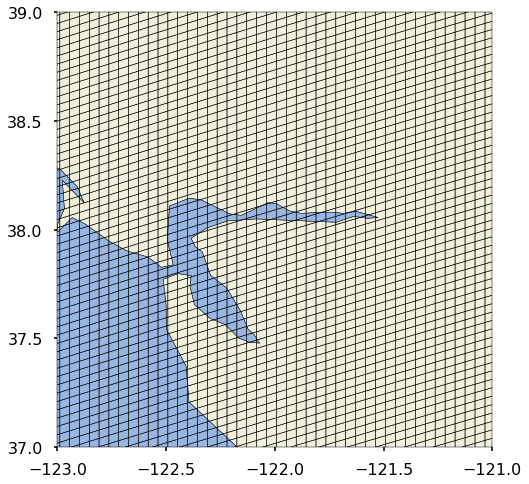

In [152]:
gen.make_map(plot_background=True)